### Solar Radiation Pressure: Various contributions

In this example we will compute the solar radiation pressure on a simple object and analyze the different contributions
- Specular reflection
- Secondary specular reflection
- Diffusion

In [1]:
from pyRTX.classes.Spacecraft import Spacecraft
from pyRTX.classes.RayTracer import RayTracer
from pyRTX.classes.PixelPlane import PixelPlane
from pyRTX.classes.SRP import SolarPressure
from pyRTX.core.analysis_utils import get_spacecraft_area
from pyRTX.visual.utils import plot_mesh
import trimesh as tm
import numpy as np
import matplotlib.pyplot as plt

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': '3D Mesh'}, xlabel='X', ylabel='Y', zlabel='Z'>)

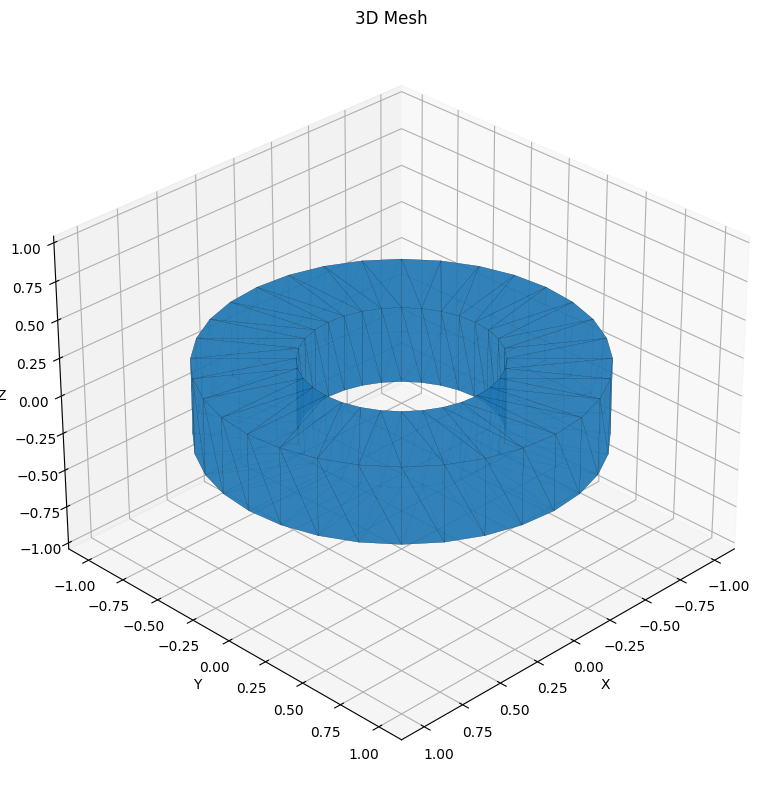

In [2]:
# Let's create a simple object that has an interesting shape for evaluating 
# advanced SRP effects
mesh = tm.creation.annulus(0.5,1,height = 0.5)
# mesh = tm.creation.icosphere()

# Define some basic information
flux = 1361 # W/m2
mass = 100


# Visualize the object
plot_mesh(mesh)

Let's now define a spaceraft object. 
The spacecraft uses the shape we have defined previously

In [3]:
sc = Spacecraft( 
            name = 'My Spacecraft',
            base_frame = 'SC Frame', # Name of the spacecraft body-fixed frame
            mass = mass, 
            units = 'm',
            spacecraft_model = { 
       
            
            'Bus': { 
                'file' : mesh,  # Note that you can also input directly a mesh (it must be trimesh.Trimesh object)
                'frame_type': 'UD', # type of frame (can be 'Spice' or 'UD'= User Defined)
                'UD_rotation' : tm.transformations.identity_matrix(), # If UD is chosen, the rotation matrix between the element and the base frame must be defined
                'frame_name': 'SC Bus', # Name of the frame
                'center': [0.0,0.0,0.0], # Origin of the component
                'diffuse': 0.3, # Diffuse reflect. coefficient
                'specular': 0.3, # Specular reflect. coefficient
                
                
            },
            },


                )


In this case we will use a fixed location for the pixel plane (i.e., the origin of the rays). 
We choose on purpose a direction that will likely generate reflections inside the annulus, so we'll be able to
assess the importance of secondary reflections

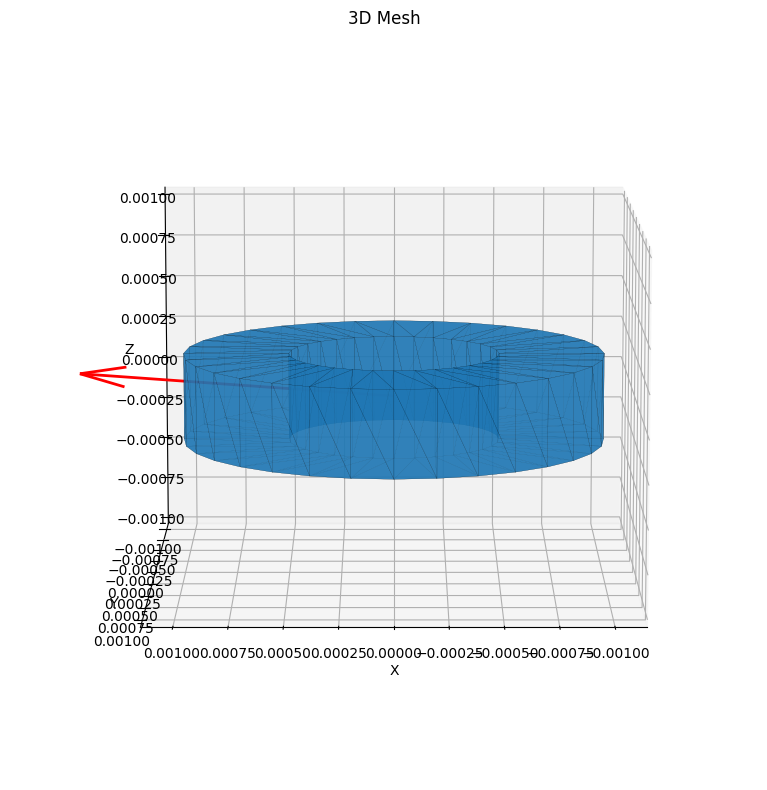

In [4]:
# Define the origin direction of the pixel plane in the spacecraft frame 
RA = 0 # rad
DEC = 5* np.pi/180 #rad

# And visualize the direction
x = np.cos(DEC)*np.cos(RA)
y = np.cos(DEC)*np.sin(RA)
z = np.sin(DEC)
start_point = [0,0,0]
direction = 0.0015*np.array([x,y,z])

fig, ax = plot_mesh(mesh, azim = 90, elev = 10)
ax.quiver(start_point[0], start_point[1], start_point[2],
          direction[0], direction[1], direction[2],
          color='red', arrow_length_ratio=0.15, linewidth=2, zorder = 10)


In [5]:
# Initialize the pixel plane
pixelPlane = PixelPlane(
        spacecraft = 'None',
        mode = 'Fixed',
        distance = 30,
        width = 5,
        height = 5,
        ray_spacing = 0.01,
        lon = RA,
        lat = DEC,
        units = 'm', 
)

# Initialize the ray-tracer explicitly requesting to compute
# up to the fourth bounce.
rtx = RayTracer(sc, 
                pixelPlane, 
                kernel = 'Embree3', 
                bounces = 4, 
                diffusion = False, 
                num_diffuse = 10)


# Asking for grouped=False allows to retrieve
# the results for each bounce individually
# Note that in this case we have to set the baseflux to None
# this is because we don't have a real spacecraft
# so no trajectory is known for this object
# if we tried to set the baseflux to some value
# the solar pressure object would try to find
# the location of the spacecraft to rescale the flux
# at the correct distance
srp = SolarPressure(sc, rtx, 
                    baseflux = None,
                    grouped = False, 
                   
                   )
# This will raise a warning, because tupically this setting
# is used for computing a lookup table (LUT)
# (See more details in the LUT example)


 *** WARNING: For LUT computation SC mass should be set to 1.0!


In [6]:
# To compute the acceleration we need to provide an epoch
# Since there are no moving parts, "None" works 
# as well. 
accel = np.array(srp.compute([None], n_cores = 1)) * flux * 1000
print(accel)

[[[-6.67300569e-08 -3.96535400e-23 -5.84437961e-09]
  [ 4.65622422e-10 -2.27309654e-26 -5.48399008e-11]
  [ 5.23924833e-12  3.35512404e-28 -1.64519703e-11]
  [-1.03436433e-12  1.26236542e-26 -4.93559108e-12]]]


Found bounces 4


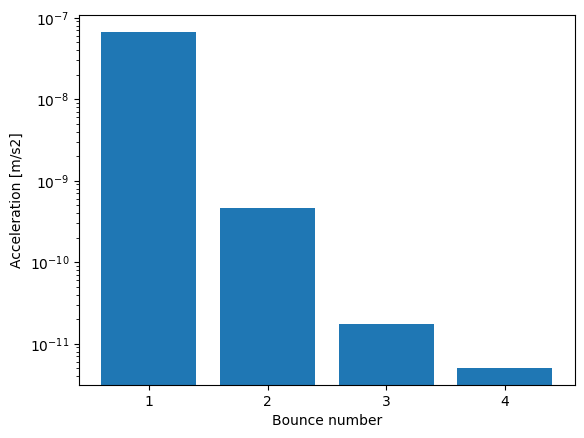

In [7]:
print(f'Found bounces {len(accel[0])}')

fig, ax = plt.subplots()
ax.bar(np.arange(1, len(accel[0])+1), np.linalg.norm(accel[0], axis = 1))
ax.set_yscale('log')
ax.set_ylabel('Acceleration [m/s2]')
ax.set_xlabel('Bounce number')
ax.set_xticks(np.arange(1, len(accel[0])+1));

With such a shallow angle, up to four bounces are found! 
This happens because the rays keep bouncing inside the inner part
of the annulus. 
Let's see what happens as the angle changes


 *** WARNING: For LUT computation SC mass should be set to 1.0!
No intersections found for bounce 2. Results provided up to bounce 1

 *** WARNING: For LUT computation SC mass should be set to 1.0!

 *** WARNING: For LUT computation SC mass should be set to 1.0!
No intersections found for bounce 9. Results provided up to bounce 8

 *** WARNING: For LUT computation SC mass should be set to 1.0!
No intersections found for bounce 7. Results provided up to bounce 6

 *** WARNING: For LUT computation SC mass should be set to 1.0!
No intersections found for bounce 6. Results provided up to bounce 5

 *** WARNING: For LUT computation SC mass should be set to 1.0!
No intersections found for bounce 5. Results provided up to bounce 4

 *** WARNING: For LUT computation SC mass should be set to 1.0!
No intersections found for bounce 5. Results provided up to bounce 4

 *** WARNING: For LUT computation SC mass should be set to 1.0!
No intersections found for bounce 4. Results provided up to bounce

Text(0.5, 0, 'Sun rays incoming angle')

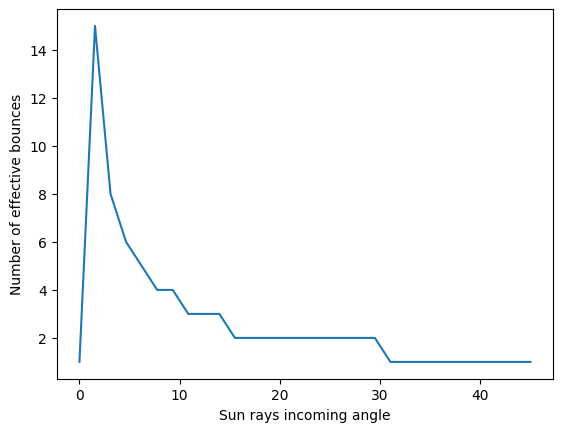

In [8]:
angles = np.linspace(0, 45*np.pi/180, 30)
n_found = np.zeros_like(angles)
for i, DEC in enumerate(angles):
    
    pixelPlane = PixelPlane(
            spacecraft = 'None',
            mode = 'Fixed',
            distance = 30,
            width = 5,
            height = 5,
            ray_spacing = 0.01,
            lon = RA,
            lat = DEC,
            units = 'm', 
    )
    
    rtx = RayTracer(sc, 
                    pixelPlane, 
                    kernel = 'Embree', 
                    bounces = 15, # Let's set a large number to see how many we get
                    diffusion = False, 
                    num_diffuse = 10)
    
    srp = SolarPressure(sc, rtx, 
                        baseflux = None,
                        grouped = False, 
                       
                       )

    accel = np.array(srp.compute([None], n_cores = 1)) * flux
    n_found[i] = len(accel[0])
fig, ax = plt.subplots()
ax.plot(angles*180/np.pi, n_found)
ax.set_ylabel('Number of effective bounces')
ax.set_xlabel('Sun rays incoming angle')

Interesting! There is a range of angles for which the light gets
almost trapped indefinitely inside the inner ring.
Let's analyze in this case how the magnitude of the acceleration 
decreases with subsequent bounces.

At the end we will plot the relative acceleration (i.e., we will normalize by the magnitude of the acceleration of the first bounce)



 *** WARNING: For LUT computation SC mass should be set to 1.0!
Found bounces 15


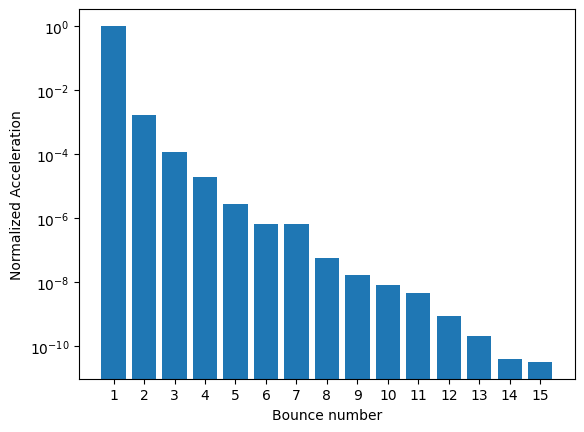

In [10]:
# Find the angle where we have the maximum number of reflections
amax = angles[np.argmax(n_found)]

pixelPlane = PixelPlane(
            spacecraft = 'None',
            mode = 'Fixed',
            distance = 30,
            width = 5,
            height = 5,
            ray_spacing = 0.01,
            lon = RA,
            lat = amax,
            units = 'm', 
    )
    
rtx = RayTracer(sc, 
                pixelPlane, 
                kernel = 'Embree3', 
                bounces = 15, # Let's set a large number to see how many we get
                diffusion = False, 
                num_diffuse = 10)

srp = SolarPressure(sc, rtx, 
                    baseflux = None,
                    grouped = False, 
                   
                   )

accel = np.array(srp.compute([None], n_cores = 1)) * flux
print(f'Found bounces {len(accel[0])}')

fig, ax = plt.subplots()
ax.bar(np.arange(1, len(accel[0])+1), np.linalg.norm(accel[0], axis = 1)/np.linalg.norm(accel[0][0]))
ax.set_yscale('log')
ax.set_ylabel('Normalized Acceleration')
ax.set_xlabel('Bounce number')
ax.set_xticks(np.arange(1, len(accel[0])+1));

## Effect of diffusion
Until now we have accounted for the sole effect of specular reflection.
This can be a very good approximation for smooth material, 
however it starts failing when rough materials, behaving like lambertian surfaces, 
are present. 

pyRTX can account for diffusion. This is done by considering each point where a ray is initially reflected (an impact point) as a source of diffusion.
Thus for each impact point we can sample a number of rays from a Lambertian distribution
and follow these rays in their subsequent interactions. 


In [11]:
# Let's see the difference between reflection only and reflection + diffusion
RA = 0
DEC = 20 * np.pi/180
pixelPlane = PixelPlane(
            spacecraft = 'None',
            mode = 'Fixed',
            distance = 30,
            width = 5,
            height = 5,
            ray_spacing = 0.01,
            lon = RA,
            lat = DEC,
            units = 'm', 
    )
    
rtx_diffuse = RayTracer(sc, 
                pixelPlane, 
                kernel = 'Embree3', 
                bounces = 2, # The diffusion is computed as a second bounce
                diffusion = True, 
                num_diffuse = 10, # This is the number of the rays diffused from the impact point
               )

rtx_specular = RayTracer(sc, 
                pixelPlane, 
                kernel = 'Embree3', 
                bounces = 2, # One bounce only this time
                diffusion = False, 
               )

srp_diffuse = SolarPressure(sc, rtx_diffuse, 
                    baseflux = None,
                    grouped = True,  # This time we are only interested in the total acceleration
                   
                   )

srp_specular = SolarPressure(sc, rtx_specular, 
                    baseflux = None,
                    grouped = True,  # This time we are only interested in the total acceleration
                   
                   )



accel_diffuse = np.array(srp_diffuse.compute([None], n_cores = 1)) * flux
accel_specular = np.array(srp_specular.compute([None], n_cores = 1)) * flux


 *** WARNING: For LUT computation SC mass should be set to 1.0!

 *** WARNING: For LUT computation SC mass should be set to 1.0!


Acceleration with only specular reflection:
[-8.89664359e-11  5.45165717e-28 -3.69518479e-11]
Acceleration with diffusive effect
[-8.81404138e-11  7.22858078e-16 -3.70486244e-11]


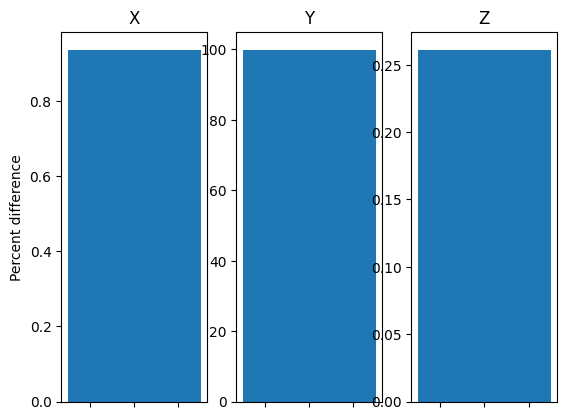

In [12]:
print('Acceleration with only specular reflection:')
print(accel_specular[0])

print('Acceleration with diffusive effect')
print(accel_diffuse[0])


fig, ax= plt.subplots(1,3)
for i in range(3):
    ax[i].bar( np.arange(0, 1), np.abs((accel_specular[0][i] - accel_diffuse[0][i] )/ accel_diffuse[0][i]) * 100, label = 'Specular only', width = 0.3)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels([])
    # ax[i].set_yscale('log')
ax[0].set_title('X')
ax[1].set_title('Y')
ax[2].set_title('Z')
ax[0].set_ylabel('Percent difference');
